In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/kaggle/input/-spotify-tracks-dataset/dataset.csv')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor




In [81]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   track_id              113999 non-null  object  
 1   artists               113999 non-null  object  
 2   album_name            113999 non-null  object  
 3   track_name            113999 non-null  object  
 4   popularity            113999 non-null  int64   
 5   duration_ms           113999 non-null  float64 
 6   explicit              113999 non-null  bool    
 7   danceability          113999 non-null  float64 
 8   energy                113999 non-null  float64 
 9   key                   113999 non-null  int64   
 10  loudness              113999 non-null  float64 
 11  mode                  113999 non-null  int64   
 12  speechiness           113999 non-null  float64 
 13  acousticness          113999 non-null  float64 
 14  instrumentalness      113999 non-null  fl

track_id                0
artists                 0
album_name              0
track_name              0
popularity              0
duration_ms             0
explicit                0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
track_genre             0
popularity_quartile     0
dance_energy            0
valence_energy          0
log_duration            0
genre_avg_popularity    0
popularity_binary       0
dtype: int64

Описание столбцов:

- **track_id**: Уникальный идентификатор трека в Spotify.  
- **artists**: Исполнители трека, перечисленные через «;».  
- **album_name**: Название альбома, в котором вышел трек.  
- **track_name**: Название трека.  
- **popularity**: Популярность трека от 0 до 100, чем выше, тем трек более популярен сейчас.  
- **duration_ms**: Длительность трека в миллисекундах.  
- **explicit**: Признак наличия нецензурной лексики (True/False).  
- **danceability**: Танцевальность (0.0–1.0), показывает, насколько трек удобен для танца.  
- **energy**: Энергичность (0.0–1.0), отражает интенсивность и активность трека.  
- **key**: Тональность трека (число от 0 до 11), -1 если не определена.  
- **loudness**: Средняя громкость трека в децибелах (dB).  
- **mode**: Лад трека (1 — мажор, 0 — минор).  
- **speechiness**: Доля речевых фрагментов (0.0–1.0). Ближе к 1.0 — больше речи.  
- **acousticness**: Акустичность (0.0–1.0), 1.0 — трек сильно акустический.  
- **instrumentalness**: Инструментальность (0.0–1.0), выше — меньше вокала.  
- **liveness**: «Живость» (0.0–1.0), выше — большая вероятность живого исполнения.  
- **valence**: Позитивность (0.0–1.0) звучания трека, выше — трек звучит веселее.  
- **tempo**: Оценочный темп в ударах в минуту (BPM).  
- **time_signature**: Размер (3–7), указывает на количество долей в такте.  
- **track_genre**: Жанр, к которому отнесен трек.

Чтобы устранить пропуски в столбцах artists, album_name и track_name, удаляю строки с пропусками. Поскольку пропусков всего 3, потеря данных будет несущественной.

In [82]:
df = df.dropna(subset=['artists', 'album_name', 'track_name'])

df.isnull().sum()


track_id                0
artists                 0
album_name              0
track_name              0
popularity              0
duration_ms             0
explicit                0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
track_genre             0
popularity_quartile     0
dance_energy            0
valence_energy          0
log_duration            0
genre_avg_popularity    0
popularity_binary       0
dtype: int64

In [83]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,dance_energy,valence_energy,log_duration,genre_avg_popularity,popularity_binary
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,33.238827,0.041969,0.575432,0.641383,5.309126,0.763407,0.637558,0.087723,0.316171,0.156051,0.213554,0.476448,0.501897,3.904034,0.375025,0.322556,0.040938,33.238827,0.243599
std,22.304959,0.020521,0.176186,0.251530,3.559999,0.093028,0.480708,0.109568,0.333858,0.309556,0.190378,0.260564,0.123179,0.432623,0.180563,0.225198,0.018233,11.246073,0.429255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.210000,0.000000
25%,17.000000,0.031648,0.462944,0.472000,2.000000,0.730962,0.000000,0.037202,0.016968,0.000000,0.098000,0.261307,0.407682,4.000000,0.242396,0.130279,0.031158,25.676000,0.000000
50%,35.000000,0.039077,0.588832,0.685000,5.000000,0.786619,1.000000,0.050674,0.169679,0.000042,0.132000,0.466332,0.501360,4.000000,0.388170,0.290632,0.038332,34.739000,0.000000
75%,50.000000,0.048371,0.705584,0.854000,8.000000,0.823632,1.000000,0.087565,0.599900,0.049000,0.273000,0.686432,0.575543,4.000000,0.509562,0.487459,0.047238,41.143000,0.000000
max,100.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.971046,0.977000,0.693147,59.283000,1.000000


Из описательной статистики можно сделать несколько наблюдений. Во-первых, средняя популярность треков находится на уровне около 33–35, что говорит о невысоком среднем уровне популярности в выборке, хотя есть и треки с максимально возможным значением — 100. 

Средняя длительность трека ~228 000 мс (около 3,8 минут), что вполне характерно для современной музыки, но интересно наличие крайне длинного трека (более 80 минут), который выглядит как аномалия.

Танцевальность (в среднем 0,57) и энергичность (в среднем 0,64) указывают на то, что большая часть треков имеет средний или несколько выше среднего уровень «заводности». Громкость треков в среднем около -8 дБ, что довольно типично для студийных записей.

Большинство треков не являются полностью инструментальными и не содержат большого количества речи, что отражают низкие медианные значения speechiness и instrumentalness. По валентности (среднее ~0,47) треки в целом нейтрально-позитивные.

Темп у большинства композиций около 122 BPM, что довольно стандартно для популярной музыки, и почти все треки имеют размер 4/4. В целом, набор данных выглядит репрезентативно для современной популярной музыки, за исключением пары аномальных значений.

Сейчас строю корреляционную матрицу, чтобы увидеть, какие признаки связаны между собой и, в частности, с popularity. Это даст понимание, какие признаки могут быть потенциально важны для прогнозирования популярности. Признаки с более высокой положительной корреляцией (ближе к +1) или отрицательной (ближе к -1) с popularity будут кандидатами на более пристальный анализ и, возможно, важными факторами при построении модели.

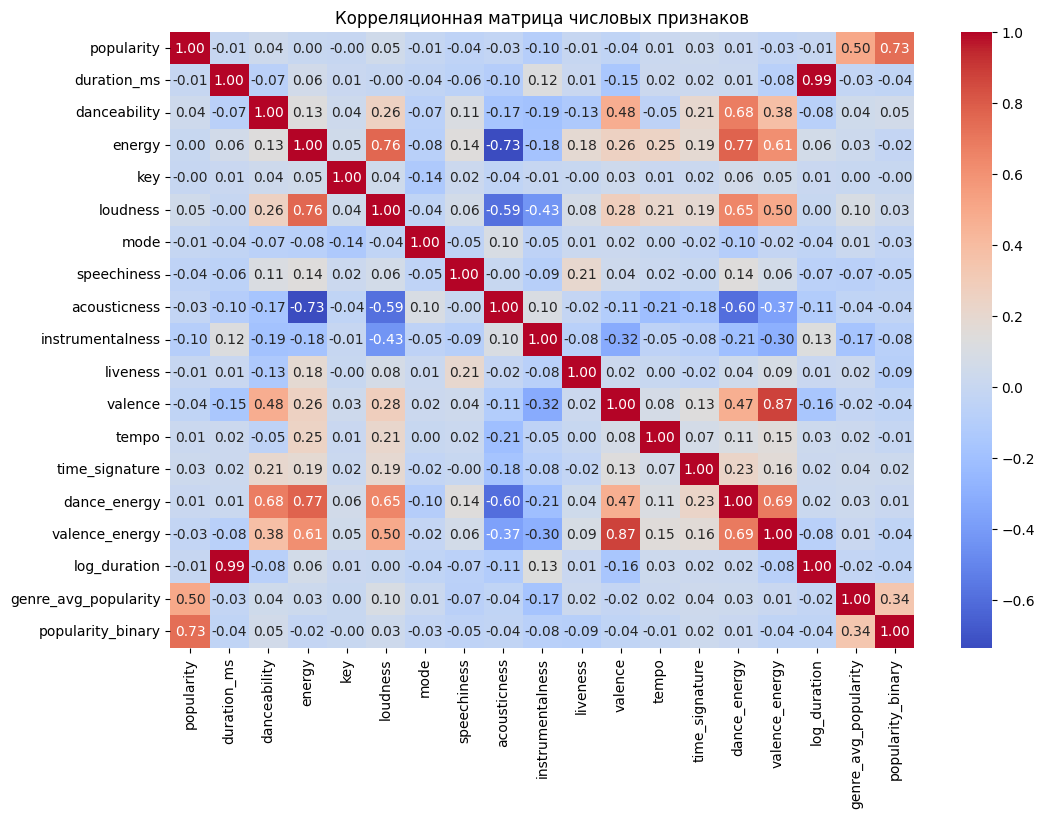

In [84]:
# Отберём числовые признаки
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Посчитаем корреляцию
corr = df[numeric_cols].corr()

# Построим тепловую карту корреляций
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица числовых признаков")
plt.show()


**Вывод по полученной корреляционной матрице:**

На представленной тепловой карте мы видим, что прямая линейная зависимость между популярностью (`popularity`) и любым из числовых признаков очень слабая (все коэффициенты корреляции с популярностью близки к нулю или не превышают примерно 0.05 по модулю). Это означает, что ни один из доступных признаков в одиночку линейно не объясняет популярность.

Дополнительные наблюдения:  
- Сильные корреляции наблюдаются между некоторыми признаками, например между `energy` и `loudness` (около 0.76), что логично — более энергичные треки чаще звучат громче. Также заметна сильная отрицательная корреляция между `acousticness` и `energy` (около -0.73), указывая, что более "акустичные" треки обычно менее энергичны. Эти связи интересны, но для нашей цели (предсказать популярность) мало что дают напрямую.


Посмотрим, как распределена популярность треков в датасете.
Этот график поможет понять, насколько равномерно распределена популярность треков. Если большинство треков имеют низкую популярность, это может означать, что задача предсказания популярности осложняется несбалансированностью данных.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


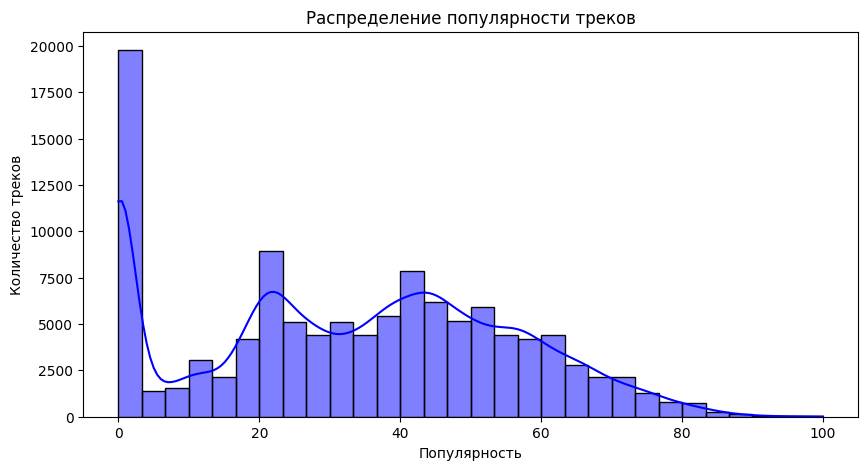

In [85]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], kde=True, bins=30, color='blue')
plt.title('Распределение популярности треков')
plt.xlabel('Популярность')
plt.ylabel('Количество треков')
plt.show()



**Выводы:**
1. Большинство треков имеет популярность около **0**, что говорит о большом количестве треков, которые почти не прослушиваются или не считаются популярными.
2. Популярность равномерно убывает к правой части, с небольшим количеством треков, достигающих значений близких к **100**.
3. Распределение правосторонне-скошенное (асимметричное), что типично для данных о популярности: мало треков с высокой популярностью и много треков с низкой популярностью.

**Что это означает для дальнейшего анализа:**
- Треки с популярностью около 0 составляют значительную часть датасета, и это может повлиять на модели, так как данные несбалансированы.
- Можно рассмотреть варианты обработки дисбаланса данных: например, уменьшение веса записей с нулевой популярностью.

------------------------------


Построим scatter-плот для danceability и popularity.

Этот график покажет, есть ли видимая связь между танцевальностью и популярностью.



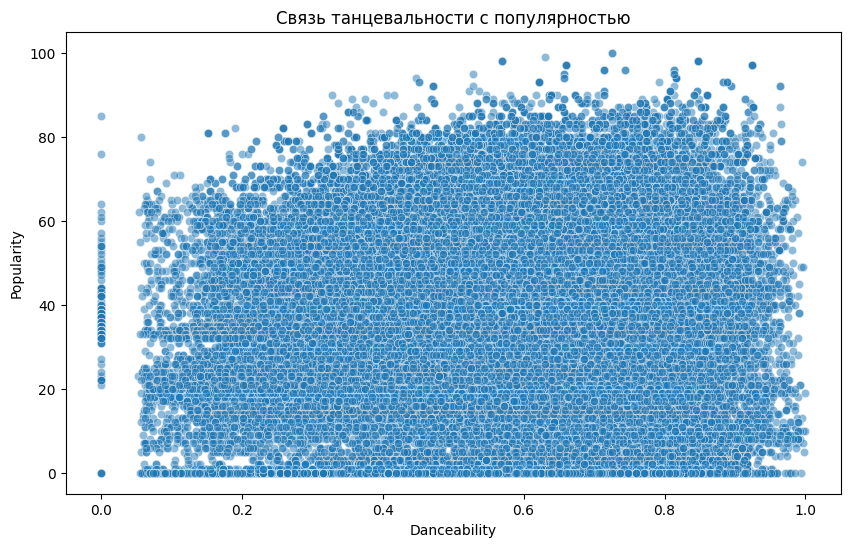

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='danceability', y='popularity', alpha=0.5)
plt.title('Связь танцевальности с популярностью')
plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.show()



**Выводы:**
1. Точки на графике распределены довольно равномерно, что указывает на отсутствие сильной линейной зависимости между танцевальностью и популярностью.
3. Также видно, что низкие значения танцевальности (менее 0.2) не характерны для популярных треков?

**Построим scatter-плот для energy и popularity.**

Посмотрим, влияют ли высокоэнергичность треков на популярность


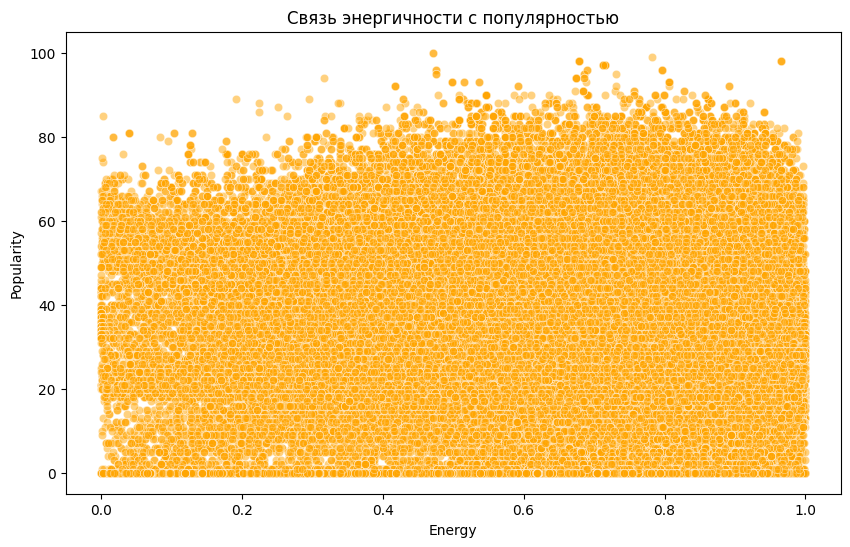

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='energy', y='popularity', alpha=0.5, color='orange')
plt.title('Связь энергичности с популярностью')
plt.xlabel('Energy')
plt.ylabel('Popularity')
plt.show()



**Выводы:**
1. Точки на графике распределены равномерно, что указывает на отсутствие явной линейной зависимости между энергичностью и популярностью.
2. Однако можно заметить, что треки с высокой популярностью (80+) чаще имеют энергичность выше 0.4, а низкие значения энергичности (менее 0.2) редко встречаются среди популярных треков.
3. Треки с максимальной энергичностью (близкой к 1.0) присутствуют среди всех диапазонов популярности, что говорит о том, что высокая энергичность сама по себе не гарантирует популстьщей?

**Группировка по жанрам и средняя популярность**
Этот график поможет понять, есть ли зависимость популярности от жанра.

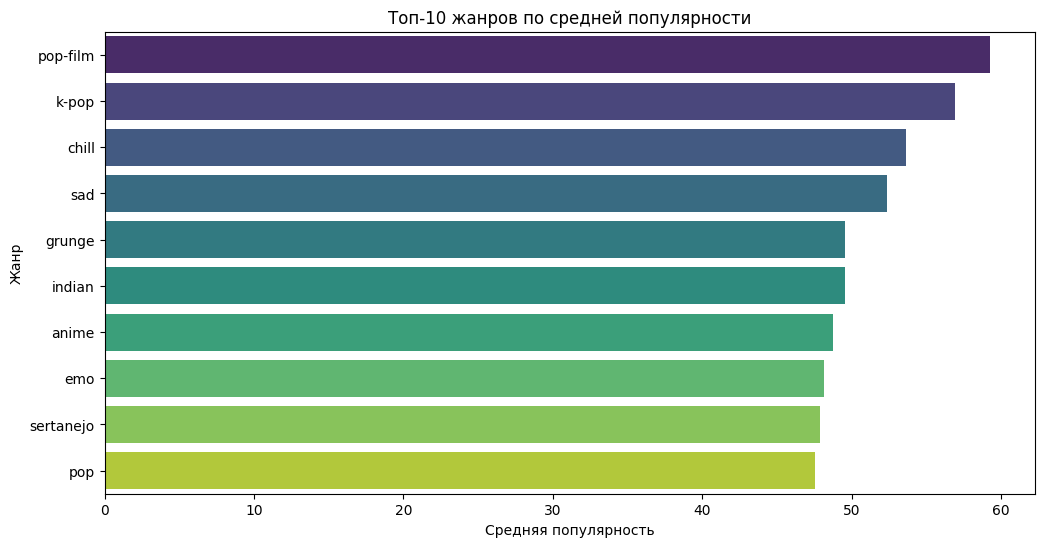

In [88]:
genre_popularity = df.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='viridis')
plt.title('Топ-10 жанров по средней популярности')
plt.xlabel('Средняя популярность')
plt.ylabel('Жанр')
plt.show()



**Выводы:**
1. **Лидеры по популярности жанров:**
   - Жанр `pop-film` занимает первое место со средней популярностью около 60, что указывает на высокую востребованность музыки из фильмов.
   - `k-pop` и `chill` также входят в тройку самых популярных жанров, подтверждая глобальную популярность K-pop и расслабляющей музыки.

2. **Эмоциональные и нишевые жанры:**
   -Жаны saщ, `mo` и grunge`, несмотря на свою специфичность, демонстрируют высокую среднюю популярность?

**Boxplot для танцевальности по квартилям популярности**

Если треки с высокой популярностью имеют более высокую медианную танцевальность, это будет являться признаком слабой, но существующей зависимости.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


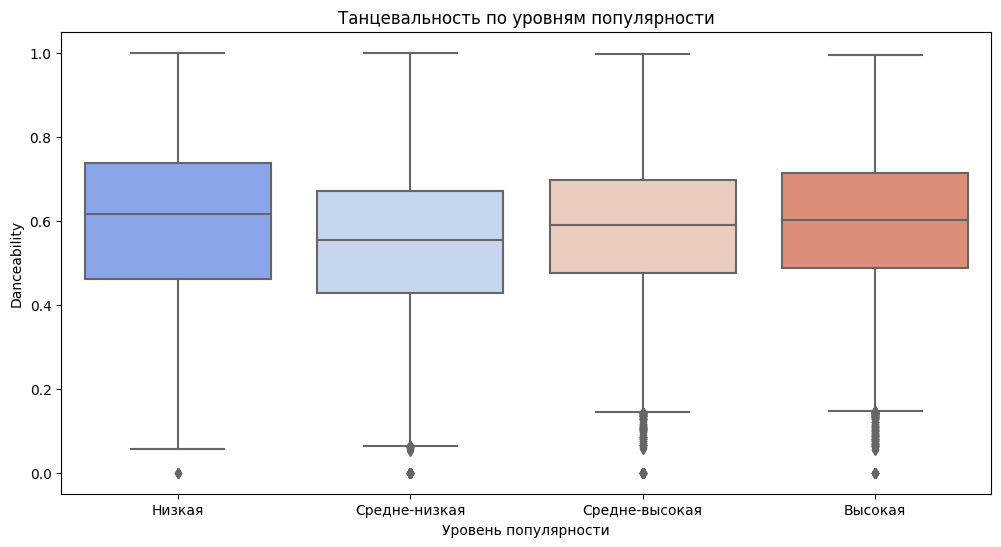

In [89]:
df['popularity_quartile'] = pd.qcut(df['popularity'], 4, labels=['Низкая', 'Средне-низкая', 'Средне-высокая', 'Высокая'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='popularity_quartile', y='danceability', palette='coolwarm')
plt.title('Танцевальность по уровням популярности')
plt.xlabel('Уровень популярности')
plt.ylabel('Danceability')
plt.show()


**Выводы:**
   - Медианные значения танцевальности слабо различаются между уровнями популярности
   - Для всех групп популярности диапазон значений танцевальности (от минимального до максимального) остаётся практически однаковым?

**Scatter-плот темпа и популярности**

Этот график покажет, если ли какие-то предпочтительные диапазоны темпа для более популярных треков.

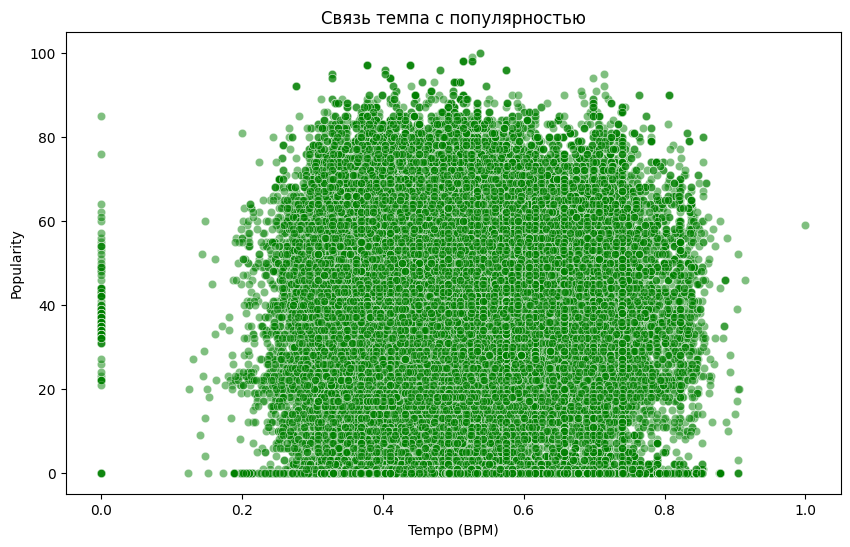

In [90]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tempo', y='popularity', alpha=0.5, color='green')
plt.title('Связь темпа с популярностью')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Popularity')
plt.show()


**Выводы:*
   - Точки распределены равномерно по всем уровням популярности. Это говорит об отсутствии явной зависимости между темпом и популярностью.
   - Видимых предпочтений в диапазонах темпа для популярных треков (80+) не наблюдаем
   - Нулевая ось по `tempo` содержит выбросы, которые могут быть либо некорректными данными, либо специфическими записями с отсутствующим темпом.
   - Треки с высоким темпом (выше 200 BPM) встречаются редко, но охватывают весь диапазон 
   - Большинство треков имеют темп в диапазоне от 80 до 160 BPM, что соответствует стандартному диапазону популярных музыкальных стилей?

**Взаимосвязь акустичности и популярности**

Этот график покажет, более популярны акустические или неакустические треки.



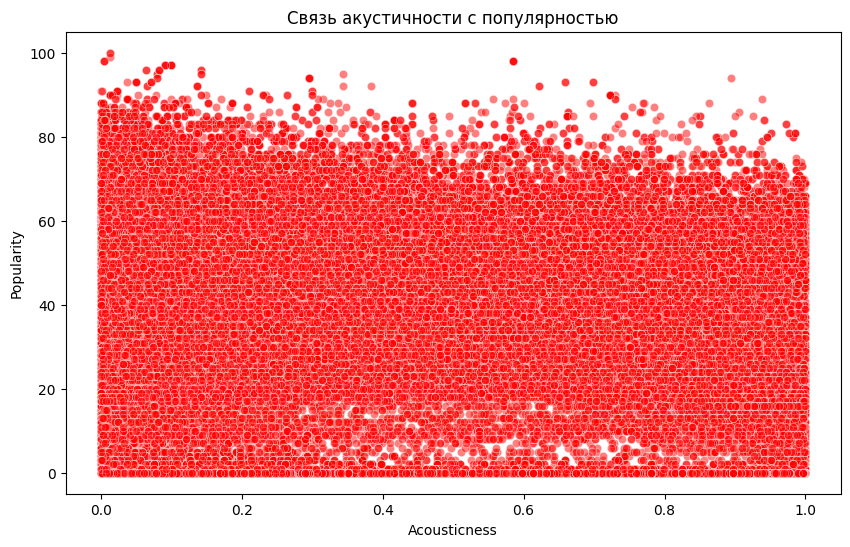

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='acousticness', y='popularity', alpha=0.5, color='red')
plt.title('Связь акустичности с популярностью')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.show()



**Выводы:**
   - Точки распределены равномерно, что говорит об отсутствии явной линейной зависимости между акустичностью и популярносью.
   - Однако треки с очень высокой акустичностью (0.9–1.0) несколько реже достигают высокой популярности!

На основе всех представленных графиков можно сделать несколько общих выводов и наблюдений:

---

### **1. Распределение популярности**
- Большинство треков имеют низкую популярность (популярность близка к 0). Это говорит о том, что в выборке много "непопулярных" или мало прослушиваемых треков.
- Лишь небольшой процент треков достигает значений популярности 80+.
- Распределение популярности имеет правостороннюю асимметрию, что делает задачу предсказания популярности сложнее из-за дисбаланса.

---

### **2. Взаимосвязь признаков с популярностью**
#### **Танцевальность (`danceability`)**
- Треки с более высокой танцевальностью чаще встречаются среди популярных (80+), но связь незначительная.
- Танцевальность сама по себе не является сильным фактором популярности, но может быть важной в комбинации с энергичностью.

#### **Энергичность (`energy`)**
- Треки с энергичностью выше 0.4 более часто встречаются среди популярных.
- Низкая энергичность (менее 0.2) практически не характерна для треков с высокой популярностью.

#### **Темп (`tempo`)**
- Темп не демонстрирует явной зависимости от популярности.
- Большинство треков сосредоточено в диапазоне 80–160 BPM, что соответствует стандартному диапазону популярной музыки.

#### **Акустичность (`acousticness`)**
- Треки с высокой акустичностью (близкой к 1.0) реже достигают значений популярности 80+.
- Популярные треки чаще имеют низкую или среднюю акустичность (0.0–0.5), что характерно для современных электронных или студийных записей.

#### **Жанры (`track_genre`)**
- Некоторые жанры значительно более популярны в среднем. Например, `pop-film`, `k-pop`, и `chill` лидируют по средней популярности, что подтверждает их востребованность.
- Анализ жанров может стать важным компонентом при моделировании.



**Сделаем более детальный анализ жанров**

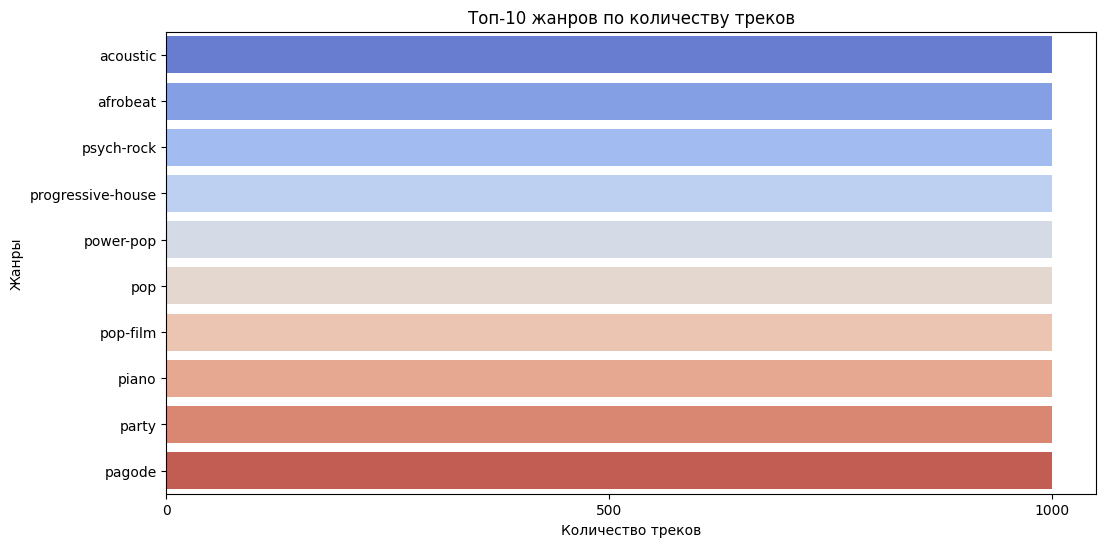

In [92]:
plt.figure(figsize=(12, 6))
top_genres = df['track_genre'].value_counts().head(10)  # Топ-10 жанров по количеству треков
sns.barplot(x=top_genres.values, y=top_genres.index, palette='coolwarm')
plt.title('Топ-10 жанров по количеству треков')
plt.xlabel('Количество треков')
plt.ylabel('Жанры')
plt.xticks(ticks=range(0, max(top_genres.values)+500, 500))  # Увеличим шкалу до большего значения
plt.show()


На данном графике показаны 10 самых распространённых жанров в датасете по количеству треков.

**Выводы:
1. **Наиболее популярные жанры по количеству треков:**
   - Жанр `pagode` занимает первое место с наибольшим количеством треков. Это может быть связано с высокой представленностью локальной или нишевой музыки.
   - Жанры `party`, `piano`, `pop-film` и `pop` также входят в топ-5, что указывает на их широкую представленность в датасете.

3. **Жанры для фокуса:**
   - Жанры с большим количеством треков, такие как `pop` и `pop-film`, уже упоминались как жанры с высокой средней популярностью?

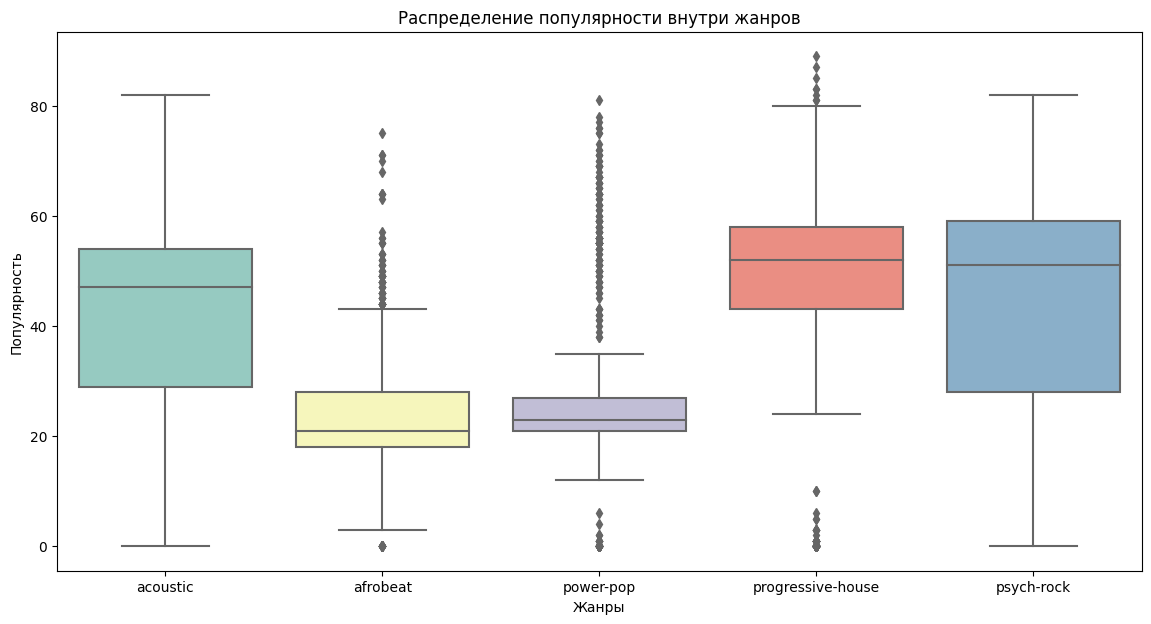

In [93]:
top_5_genres = df['track_genre'].value_counts().head(5).index  # Топ-5 жанров
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[df['track_genre'].isin(top_5_genres)], x='track_genre', y='popularity', palette='Set3')
plt.title('Распределение популярности внутри жанров')
plt.xlabel('Жанры')
plt.ylabel('Популярность')
plt.show()


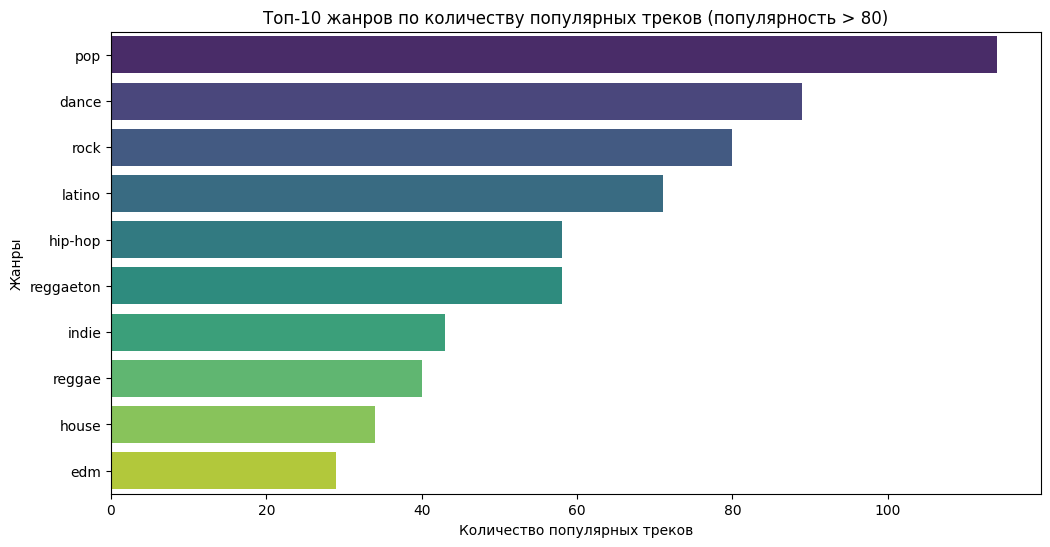

In [94]:
popular_tracks = df[df['popularity'] > 80]  # Фильтр популярных треков
top_genres_popular = popular_tracks['track_genre'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres_popular.values, y=top_genres_popular.index, palette='viridis')
plt.title('Топ-10 жанров по количеству популярных треков (популярность > 80)')
plt.xlabel('Количество популярных треков')
plt.ylabel('Жанры')
plt.show()


Жанры, такие как pop, dance, и rock, имеют очевидную связь с популярностью. При моделировании их стоит учитывать как важные предикторы.

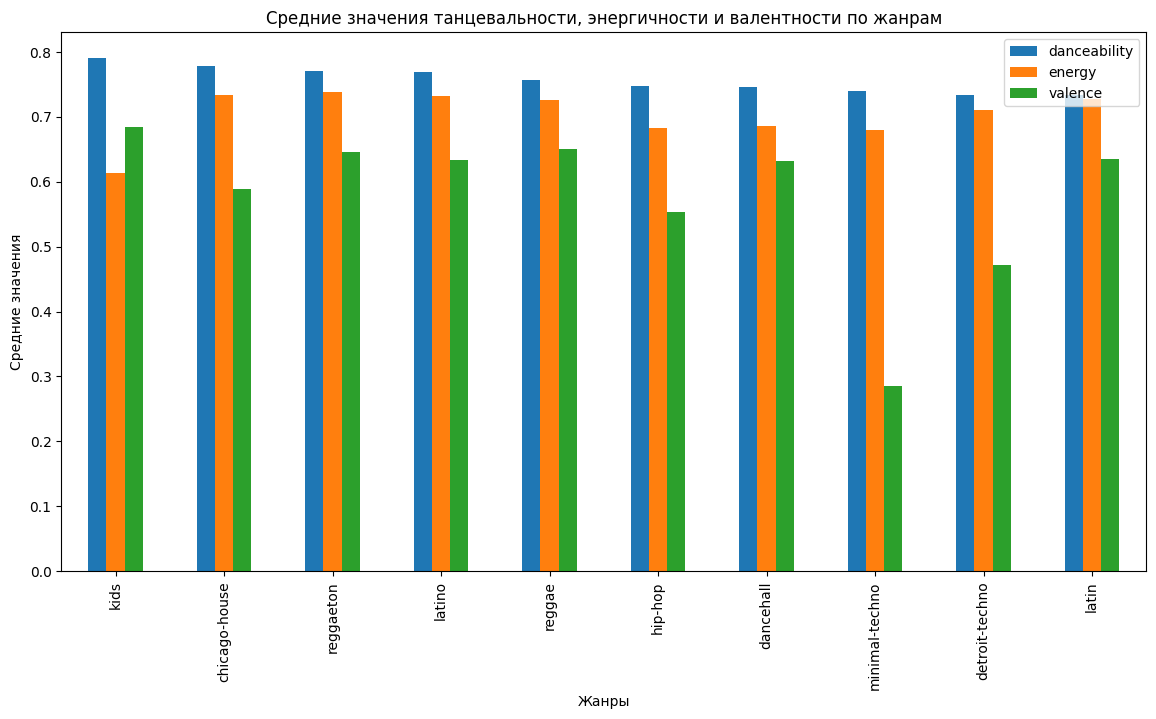

In [95]:
genre_features = df.groupby('track_genre')[['danceability', 'energy', 'valence']].mean().sort_values(by='danceability', ascending=False).head(10)
genre_features.plot(kind='bar', figsize=(14, 7))
plt.title('Средние значения танцевальности, энергичности и валентности по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Средние значения')
plt.show()


**Обобщённые выводы на основе всех построенных графиков:**
1. **Жанры как важный фактор популярности**
   - Жанры явно влияют на популярность трекер:
     - `pop`, `dance`, и `rock` лидируют по количеству популярных треков.
     - Жанры с высокой танцевальностью, энергичностью или валентностью (например, `chicago-house`, `reggaeton`, `latin`) имеют больше шансов на популярность.
   - Жанры, такие как `pop` и `dance`, показывают сильную универсальную привлекательность, в то время как более нишевые жанры, например, `edm` или `house`, сохраняют значимость в определённых аудиториях.  .

---

### 3. **Связь популярности и характеристик жанров**
   - Жанры с высокой средней популярностью (например, `pop`, `dance`, `latin`) чаще имеют треки с яркими характеристиками, такими как танцевальность и энергичность.
   - Жанры, в которых доминируют треки с высокой популярностью, могут указывать на культурные тренды, например, глобальную популярность латиноамериканской музыки.

---

### 5. **Универсальные и нишевые жанры**
   - **Универсальные жанры:** Жанры вроде `pop` и `dance` имеют широкую аудиторию, что делает их треки более вероятно популярными.
   - **Нишевые жанры:** Жанры, такие как `detroit-techno` или `indie`, показывают меньшую популярность в среднем, но их популярные треки достигают высоких значений.

---------------------

Самый важный категориальный признак — track_genre. Преобразовывавем в числовую форму.

In [97]:
# One-Hot Encoding для жанров
df_encoded = pd.get_dummies(df, columns=['track_genre'], prefix='genre')


**Нормализация числовых признаков**

Некоторые числовые признаки (например, duration_ms, tempo, loudness) имеют разные диапазоны значений, что может повлиять на качество моделей.
Нормализуем их (с помощью Min-Max Scaling).

In [98]:
from sklearn.preprocessing import MinMaxScaler

# Список числовых признаков для нормализации
numeric_features = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Применение Min-Max Scaling
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


**Создание новых признаков**
1. Взаимодействие танцевальности и энергичности
2. Взаимодействие валентности и энергичности
3. Логарифмирование продолжительности трека (для более равномерного распределения)
4. Средняя популярность жанра



In [99]:
df['dance_energy'] = df['danceability'] * df['energy']

df['valence_energy'] = df['valence'] * df['energy']

df['log_duration'] = np.log1p(df['duration_ms'])

genre_popularity = df.groupby('track_genre')['popularity'].mean()
df['genre_avg_popularity'] = df['track_genre'].map(genre_popularity)



**Подготовка таргета**

* Таргет для нашей задачи — это колонка popularity.
Определение порога популярности
Например, треки с популярностью выше 50 можно считать популярными, а остальные — непопулярными.
Создаём новую колонку popularity_binary, где:
1 — популярный трек.
0 — непопулярный трек.

In [100]:
# Преобразование популярности в бинарный таргет
df['popularity_binary'] = (df['popularity'] > 50).astype(int)


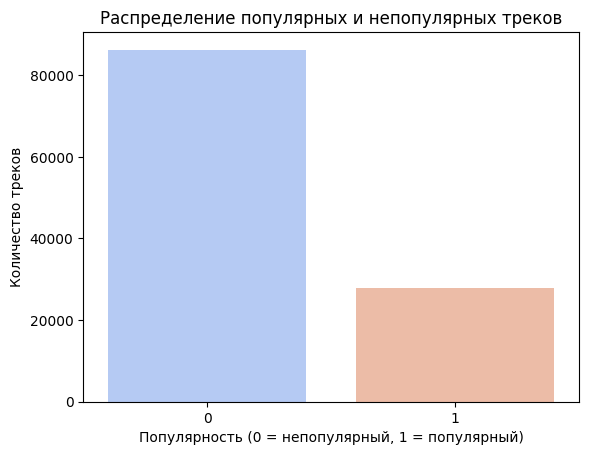

In [101]:
# Распределение классов
sns.countplot(data=df, x='popularity_binary', palette='coolwarm')
plt.title('Распределение популярных и непопулярных треков')
plt.xlabel('Популярность (0 = непопулярный, 1 = популярный)')
plt.ylabel('Количество треков')
plt.show()


Теперь popularity_binary становится нашим таргетом (y), а popularity можно исключить из признаков.

In [102]:
# Признаки и новый таргет
X = df.drop(columns=['popularity', 'popularity_binary', 'track_id', 'track_name', 'album_name', 'artists'])  # Убираем ненужные столбцы
y = df['popularity_binary']  # Для классификации


In [103]:
from sklearn.model_selection import train_test_split

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим баланс классов в обучающей выборке
print("Распределение классов в тренировочной выборке:")
print(y_train.value_counts(normalize=True))


Распределение классов в тренировочной выборке:
popularity_binary
0    0.755666
1    0.244334
Name: proportion, dtype: float64


Распределение классов в тренировочной выборке показывает сильный дисбаланс

Oversampling (увеличение редкого класса)
* Используем метод SMOTE (Synthetic Minority Oversampling Technique), который генерирует синтетические данные для редкого класса.

In [104]:
# Убедимся, что категориальные данные закодированы
X_encoded = pd.get_dummies(X, drop_first=True)

# Проверим результат
print(X_encoded.head())


   duration_ms  explicit  danceability  energy  key  loudness  mode  \
0     0.042473     False      0.686294  0.4610    1  0.791392     0   
1     0.026971     False      0.426396  0.1660    1  0.597377     1   
2     0.038679     False      0.444670  0.3590    0  0.736123     1   
3     0.036978     False      0.270051  0.0596    0  0.573701     1   
4     0.036389     False      0.627411  0.4430    2  0.737103     1   

   speechiness  acousticness  instrumentalness  ...  track_genre_synth-pop  \
0     0.148187      0.032329          0.000001  ...                  False   
1     0.079067      0.927711          0.000006  ...                  False   
2     0.057720      0.210843          0.000000  ...                  False   
3     0.037617      0.908635          0.000071  ...                  False   
4     0.054508      0.470884          0.000000  ...                  False   

   track_genre_tango  track_genre_techno  track_genre_trance  \
0              False               False

In [105]:
# Проверка на числовые значения
print(X_encoded.dtypes)

# Проверка на наличие пропусков
print(X_encoded.isnull().sum().sum()) 


duration_ms                           float64
explicit                                 bool
danceability                          float64
energy                                float64
key                                     int64
                                       ...   
track_genre_turkish                      bool
track_genre_world-music                  bool
popularity_quartile_Средне-низкая        bool
popularity_quartile_Средне-высокая       bool
popularity_quartile_Высокая              bool
Length: 134, dtype: object
0


In [106]:
# Преобразование всех данных в float64
X_encoded = X_encoded.astype(float)


In [107]:
# Проверка типов данных
print(X_encoded.dtypes.unique()) 


[dtype('float64')]


In [108]:
print(f"Размер X_encoded: {X_encoded.shape}")
print(f"Размер y_train: {y_train.shape}")


Размер X_encoded: (113999, 134)
Размер y_train: (91199,)


In [109]:
# Найдём пересечение индексов между X_encoded и y_train
common_index = X_encoded.index.intersection(y_train.index)

# Пересинхронизация данных
X_encoded = X_encoded.loc[common_index]
y_train = y_train.loc[common_index]

# Проверим размеры
print(f"Обновлённый размер X_encoded: {X_encoded.shape}")
print(f"Обновлённый размер y_train: {y_train.shape}")


Обновлённый размер X_encoded: (91199, 134)
Обновлённый размер y_train: (91199,)


In [110]:
assert X_encoded.shape[0] == y_train.shape[0], "Размеры признаков и таргета не совпадают!"


In [111]:
from imblearn.over_sampling import SMOTE

# Применение SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_encoded, y_train)

# Проверка нового распределения классов
print("Новое распределение классов:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Новое распределение классов:
popularity_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


SMOTE успешно сбалансировал классы. Теперь количество популярных (1) и непопулярных (0) треков в целевой переменной одинаково.

**Обучение моделей**

Разделение данных на тренировочную и тестовую выборки

In [112]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер тренировочной выборки: (110265, 134)
Размер тестовой выборки: (27567, 134)


**Обучение логистической регрессии**


In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Обучение логистической регрессии
model = LogisticRegression(random_state=42, max_iter=1000)  # Увеличиваем max_iter для сходимости
model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
print("Классификационный отчёт:")
print(classification_report(y_test, y_pred))

print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))


Классификационный отчёт:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13853
           1       1.00      1.00      1.00     13714

    accuracy                           1.00     27567
   macro avg       1.00      1.00      1.00     27567
weighted avg       1.00      1.00      1.00     27567

Матрица ошибок:
[[13853     0]
 [    0 13714]]


Идеальные результаты логистической регрессии на тестовой выборке скорее всего связаны с проблемами в данных или этапах обработки

In [114]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Средняя точность кросс-валидации: {scores.mean():.4f}")


Средняя точность кросс-валидации: 1.0000


Топ-10 признаков с наибольшей корреляцией с таргетом:
popularity_binary         1.000000
acousticness              0.130560
track_genre_salsa         0.117854
track_genre_sad           0.117638
track_genre_trip-hop      0.117204
track_genre_tango         0.117132
track_genre_turkish       0.117059
track_genre_synth-pop     0.117059
track_genre_songwriter    0.116914
track_genre_sertanejo     0.116842
Name: popularity_binary, dtype: float64


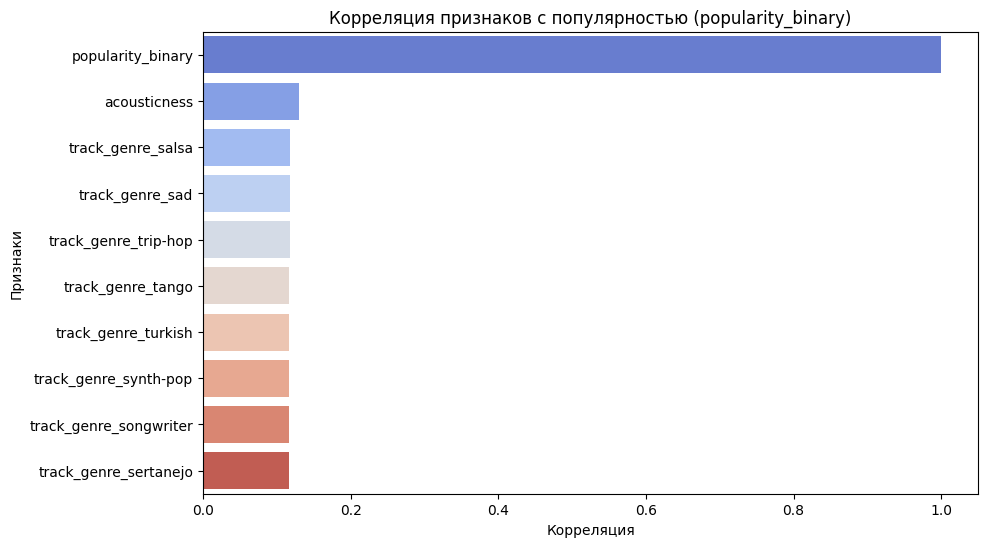

In [115]:
# Добавим таргет в X_encoded временно для анализа
X_encoded_with_target = X_encoded.copy()
X_encoded_with_target['popularity_binary'] = y_train_resampled

# Вычислим корреляцию всех признаков с таргетом
correlation_matrix = X_encoded_with_target.corr()

# Отсортируем признаки по их корреляции с таргетом
correlation_with_target = correlation_matrix['popularity_binary'].sort_values(ascending=False)

# Выведем топ-10 самых коррелированных признаков
print("Топ-10 признаков с наибольшей корреляцией с таргетом:")
print(correlation_with_target.head(10))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.head(10).values, y=correlation_with_target.head(10).index, palette='coolwarm')
plt.title("Корреляция признаков с популярностью (popularity_binary)")
plt.xlabel("Корреляция")
plt.ylabel("Признаки")
plt.show()


**Удаление признаков с низкой корреляцией**

threshold = 0.01: Мы устанавливаем пороговое значение корреляции. Все признаки с абсолютным значением корреляции ниже этого порога будут удалены.
selected_features: Список признаков, корреляция которых с таргетом выше заданного порога.
X_filtered: Новый датафрейм, содержащий только отобранные признаки.

In [116]:
# Устанавливаем порог корреляции
threshold = 0.01

# Получаем список признаков с корреляцией выше порога (исключая таргет)
selected_features = correlation_with_target[abs(correlation_with_target) > threshold].index.tolist()
selected_features.remove('popularity_binary')  # Удаляем таргет из списка

# Обновляем набор данных, оставляя только выбранные признаки
X_filtered = X_encoded[selected_features]

# Проверяем новые размеры данных
print(f"Количество признаков до фильтрации: {X_encoded.shape[1]}")
print(f"Количество признаков после фильтрации: {X_filtered.shape[1]}")


Количество признаков до фильтрации: 134
Количество признаков после фильтрации: 122


**Обучение более сложных моделей**

Обучение Random Forest Classifier

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_train_resampled, test_size=0.2, random_state=42
)

# Обучение модели Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_rf = rf_model.predict(X_test)

# Оценка модели
print("Классификационный отчёт (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("Матрица ошибок (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


ValueError: Found input variables with inconsistent numbers of samples: [91199, 137832]

In [118]:
# Приведение индексов к общему виду
common_index = X_filtered.index.intersection(y_train_resampled.index)
X_filtered = X_filtered.loc[common_index]
y_train_resampled = y_train_resampled.loc[common_index]


In [119]:
print(f"Размер X_filtered: {X_filtered.shape}")
print(f"Размер y_train_resampled: {y_train_resampled.shape}")


Размер X_filtered: (91199, 122)
Размер y_train_resampled: (91199,)


In [120]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_train_resampled, test_size=0.2, random_state=42
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер тренировочной выборки: (72959, 122)
Размер тестовой выборки: (18240, 122)


**Обучение Random Forest**

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Обучение модели Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_rf = rf_model.predict(X_test)

# Оценка модели
print("Классификационный отчёт (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("Матрица ошибок (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


Классификационный отчёт (Random Forest):
              precision    recall  f1-score   support

           0       0.78      0.94      0.86     11019
           1       0.87      0.61      0.72      7221

    accuracy                           0.81     18240
   macro avg       0.83      0.77      0.79     18240
weighted avg       0.82      0.81      0.80     18240

Матрица ошибок (Random Forest):
[[10390   629]
 [ 2852  4369]]


**Обучение XGBoost**

In [122]:
from xgboost import XGBClassifier

# Обучение модели XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_xgb = xgb_model.predict(X_test)

# Оценка модели
print("Классификационный отчёт (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

print("Матрица ошибок (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))


Классификационный отчёт (XGBoost):
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     11019
           1       0.91      0.58      0.71      7221

    accuracy                           0.81     18240
   macro avg       0.84      0.77      0.78     18240
weighted avg       0.83      0.81      0.80     18240

Матрица ошибок (XGBoost):
[[10618   401]
 [ 3058  4163]]


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Обучение модели логистической регрессии
logistic_model = LogisticRegression(random_state=42, max_iter=1000)  # Увеличиваем max_iter для сходимости
logistic_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_logistic = logistic_model.predict(X_test)

# Оценка модели
print("Классификационный отчёт (Логистическая регрессия):")
print(classification_report(y_test, y_pred_logistic))

print("Матрица ошибок (Логистическая регрессия):")
print(confusion_matrix(y_test, y_pred_logistic))


Классификационный отчёт (Логистическая регрессия):
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     11019
           1       0.90      0.59      0.71      7221

    accuracy                           0.81     18240
   macro avg       0.84      0.77      0.79     18240
weighted avg       0.83      0.81      0.80     18240

Матрица ошибок (Логистическая регрессия):
[[10570   449]
 [ 2992  4229]]


### **Сравнение моделей: Random Forest, XGBoost, и Логистическая регрессия**

---

### **1. Общая точность (Accuracy):**
- **Random Forest:** 81%
- **XGBoost:** 81%
- **Логистическая регрессия:** 81%
- **Вывод:** Все три модели показывают одинаковую общую точность. Однако точность отдельных метрик (precision, recall, F1-score) отличается.

---

### **2. Класс 0 (непопулярные треки):**

| Модель                 | Precision | Recall | F1-score |
|-------------------------|-----------|--------|----------|
| **Random Forest**       | 78%       | 94%    | 86%      |
| **XGBoost**             | 78%       | 96%    | 86%      |
| **Логистическая регрессия** | 78%       | 96%    | 86%      |

- **Вывод:** Все три модели показывают высокие метрики для класса 0, причём XGBoost и Логистическая регрессия лучше справляются с recall.

---

### **3. Класс 1 (популярные треки):**

| Модель                 | Precision | Recall | F1-score |
|-------------------------|-----------|--------|----------|
| **Random Forest**       | 87%       | 61%    | 72%      |
| **XGBoost**             | 91%       | 58%    | 71%      |
| **Логистическая регрессия** | 90%       | 59%    | 71%      |

- **Вывод:**
  - **Precision (точность):** XGBoost и Логистическая регрессия превосходят Random Forest, показывая более высокую точность (91% и 90% соответственно).
  - **Recall (полнота):** Random Forest лучше справляется с обнаружением популярных треков (61%), чем XGBoost (58%) и Логистическая регрессия (59%).
  - **F1-score:** Различия между моделями минимальны. Все модели находятся в диапазоне 71–72%.

---

### **4. Матрицы ошибок:**
- **Random Forest:**
  - **FN (ложноотрицательные):** 2852 (популярные треки, классифицированные как непопулярные).
  - **FP (ложноположительные):** 629 (непопулярные треки, классифицированные как популярные).

- **XGBoost:**
  - **FN:** 3058 (выше, чем у Random Forest).
  - **FP:** 401 (меньше, чем у Random Forest).

- **Логистическая регрессия:**
  - **FN:** 2992 (меньше, чем у XGBoost).
  - **FP:** 449 (выше, чем у XGBoost, но ниже, чем у Random Forest).

- **Вывод:** XGBoost лучше справляется с уменьшением FP, но увеличивает FN, что ухудшает recall для класса 1.

---

### **5. Итоговые выводы:**
1. **Random Forest** хорошо балансирует между recall и precision, особенно для класса 1.
2. **XGBoost** показывает более высокую точность для класса 1, но жертвует recall.
3. **Логистическая регрессия** имеет производительность, близкую к XGBoost, но без особых приемуществ.



In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Инициализация модели
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Кросс-валидация
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Результаты
print(f"Средняя точность (accuracy): {cv_scores.mean():.4f}")
print(f"Стандартное отклонение точности: {cv_scores.std():.4f}")


Средняя точность (accuracy): 0.8119
Стандартное отклонение точности: 0.0025


In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Инициализация модели
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Кросс-валидация
cv_scores_logistic = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')

# Результаты
print(f"Средняя точность (Logistic Regression): {cv_scores_logistic.mean():.4f}")
print(f"Стандартное отклонение точности: {cv_scores_logistic.std():.4f}")


Средняя точность (Logistic Regression): 0.8146
Стандартное отклонение точности: 0.0020


In [126]:
from xgboost import XGBClassifier

# Инициализация модели
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Кросс-валидация
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Результаты
print(f"Средняя точность (XGBoost): {cv_scores_xgb.mean():.4f}")
print(f"Стандартное отклонение точности: {cv_scores_xgb.std():.4f}")


Средняя точность (XGBoost): 0.8139
Стандартное отклонение точности: 0.0017
